<a href="https://colab.research.google.com/github/Nov05/yelp-dataset-challenge/blob/master/notebooks/2019_12_15_keyword_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# created by nov05 on 2019-12-15

Keyphrase Extraction from Scholarly Articles as Sequence   
Labeling using Contextualized Embeddings   
https://arxiv.org/pdf/1910.08840.pdf   

GitHub Repo - BERT Keyphrase Extraction    
https://github.com/pranav-ust/BERT-keyphrase-extraction    

BERT - Word vectors, sentence vectors, cosine similarity    
https://colab.research.google.com/drive/1wnKvhn2JEPgM11SwxUQZSgaty2iHPiYy    

BERT: Pre-training of Deep Bidirectional   
Transformers for Language Understanding  
(Bidirectional Encoder Representations from Transformers)   
Jacob Devlin, Google AI Language   
https://nlp.stanford.edu/seminar/details/jdevlin.pdf   


# Installations

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
# https://spacy.io/models
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [0]:
!pip install pytextrank
# Successfully installed pytextrank-2.0.0

In [0]:
# for spaCy lemmatizer 
# https://spacy.io/usage/adding-languages#lemmatizer
# https://spacy.io/api/lemmatizer
# !git clone https://github.com/explosion/spacy-lookups-data
%cd spacy-lookups-data
!pip install -r requirements.txt
!pip install spacy_lookups_data
# !python -m pytest spacy_lookups_data
'''
Successfully installed spacy-lookups-data-0.2.0
WARNING: The following packages were previously imported in this runtime:
  [spacy_lookups_data]
You must restart the runtime in order to use newly installed versions.
'''

In [0]:
!pip install pytorch_pretrained_bert
# Successfully installed pytorch-pretrained-bert-0.6.2 regex-2019.12.9

In [0]:
# https://networkx.github.io/documentation/networkx-1.9/install.html
!pip install networkx
# Requirement already satisfied: networkx in /usr/local/lib/python3.6/dist-packages (2.4)
# Requirement already satisfied: decorator>=4.3.0 in /usr/local/lib/python3.6/dist-packages (from networkx) (4.4.1)

# Imports


In [0]:
import numpy as np
import pandas as pd
import re
from collections import Counter
from datetime import datetime 
from datetime import timedelta
import json

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import spacy
# import spacy_lookups_data
import pytextrank

# from wordcloud import WordCloud, STOPWORDS, \
#     ImageColorGenerator
# import torch
# from pytorch_pretrained_bert import BertTokenizer, \
#     BertModel, BertForMaskedLM

# from PIL import Image

# Load business_review_cafes_az.csv

In [9]:
# All businesses and reviews in state Arizona
path = "/content/drive/My Drive/data/2019-12-06 yelp/yelp_dataset/csv_out/business_review_cafes_az.csv"
df_cafes = pd.read_csv(path)
print(df_cafes.shape)
df_cafes.sample()

(21496, 75)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (51,59) have mixed types. Specify dtype option on import or set low_memory=False.



,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,is_open,categories,hours,attributes.GoodForKids,attributes.RestaurantsReservations,attributes.GoodForMeal,attributes.BusinessParking,attributes.Caters,attributes.NoiseLevel,attributes.RestaurantsTableService,attributes.RestaurantsTakeOut,attributes.RestaurantsPriceRange2,attributes.OutdoorSeating,attributes.BikeParking,attributes.Ambience,attributes.HasTV,attributes.WiFi,attributes.Alcohol,attributes.RestaurantsAttire,attributes.RestaurantsGoodForGroups,attributes.RestaurantsDelivery,hours.Monday,hours.Tuesday,hours.Wednesday,hours.Thursday,hours.Friday,hours.Saturday,hours.Sunday,attributes.BusinessAcceptsCreditCards,attributes,attributes.BusinessAcceptsBitcoin,attributes.ByAppointmentOnly,attributes.AcceptsInsurance,attributes.Music,attributes.GoodForDancing,attributes.CoatCheck,attributes.HappyHour,attributes.BestNights,attributes.WheelchairAccessible,attributes.DogsAllowed,attributes.BYOBCorkage,attributes.DriveThru,attributes.Smoking,attributes.AgesAllowed,attributes.HairSpecializesIn,attributes.Corkage,attributes.BYOB,attributes.DietaryRestrictions,attributes.Open24Hours,attributes.RestaurantsCounterService,review_id,user_id,stars_y,useful,funny,cool,text,date,datetime,year,month,day,hour,weekday,text_length
21184,WB7346WSdkTHvtHfWPilaA,Be Coffee + Food + Stuff,214 E Roosevelt St,Phoenix,AZ,85004,33.458966,-112.070489,4.5,334,1,"Restaurants, Cafes, Food, Coffee & Tea, Breakf...",NaN,True,False,"{'dessert': False, 'latenight': False, 'lunch'...","{'garage': False, 'street': True, 'validated':...",True,'average',False,True,1.0,True,True,"{'touristy': False, 'hipster': True, 'romantic...",False,u'free',u'none','casual',True,False,0:0-0:0,6:0-20:0,6:0-20:0,6:0-20:0,6:0-20:0,6:30-15:30,7:30-20:0,True,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nQv-CHmyK7AiOnVV8dxJEw,LinConb_vJCG0sY84CC4TQ,5.0,0,0,0,Stopped in here for a breakfast sandwich prior...,2018-05-28 19:01:56,2018-05-28 19:01:56,2018.0,5.0,28.0,19.0,0.0,720


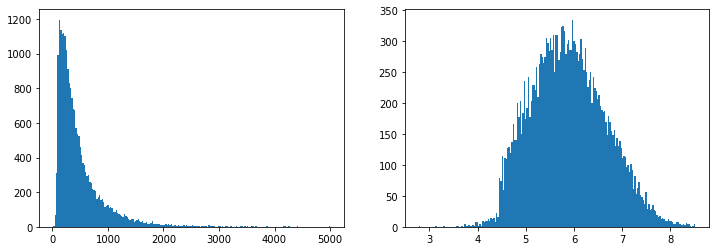

In [0]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(df_cafes['text_length'], bins=200)
plt.subplot(122)
plt.hist(np.log1p(df_cafes['text_length']), bins=200);
# most lengths are around e^6=403 words

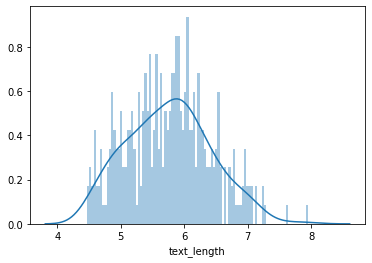

In [0]:
# for one cafe the length distribution is similar to 
# that of the total reviews of 175 cafes in Phoenix, Arizona
sns.distplot(np.log1p(df_cafes[df_cafes['business_id']
                               =='WB7346WSdkTHvtHfWPilaA']['text_length']), 
             bins=100);

In [0]:
df_reviews = df_cafes[df_cafes['business_id']=='WB7346WSdkTHvtHfWPilaA']
df_reviews[['year', 'month', 'review_id']].groupby(['year', 'month']).count().T
# this business doesn't have many reviews.  

year      2015.0                           ... 2018.0                         
month       7.0  8.0  9.0  10.0 11.0 12.0  ...   6.0  7.0  8.0  9.0  10.0 11.0
review_id      1    6    1    4    6   10  ...      4   11    2   11    6    1

[1 rows x 41 columns]

# Cafe in Phoenix with the most reviews



In [0]:
(df_cafes[['business_id', 'review_id']]
    .groupby('business_id')
    .count()
    .sort_values('review_id', ascending=False)
    .head())
# Iq7NqQD-sESu3vr9iEGuTA has the most reviews

,review_id
business_id,
Iq7NqQD-sESu3vr9iEGuTA,1310
uKKNw68mZZaa1jcyszEbyA,841
qQCsLGMncJp1xWUGnOKCQA,723
WBt2pa7k_K2LKW2OJuXG9Q,720
2DmTw0k3bcXuHdAyxO_bkw,599


In [0]:
df_reviews = df_cafes[df_cafes['business_id']=='Iq7NqQD-sESu3vr9iEGuTA']
df_reviews[['year', 'month', 'review_id']].groupby(['year', 'month']).count().T
# all businesses in the dataset don't have many reviews per month

year      2011.0                           ... 2018.0                         
month       4.0  5.0  6.0  7.0  8.0  9.0   ...   6.0  7.0  8.0  9.0  10.0 11.0
review_id      2    6    4    2    3    2  ...     24   33   23   28   19   15

[1 rows x 92 columns]

# Get reviews for a cafe

Keywords Extraction with Ngram and Modified Skip-gram based on spaCy    
https://medium.com/reputation-com-datascience-blog/keywords-extraction-with-ngram-and-modified-skip-gram-based-on-spacy-14e5625fce23    

In [0]:
business_id = 'Iq7NqQD-sESu3vr9iEGuTA'
condition = ((df_cafes['business_id']==business_id) &
             (df_cafes['year']==2018) &
             (df_cafes['month']==5))
df_reviews = df_cafes[condition][['review_id', 'text', 'year', 'month', 'date']]
df_reviews.shape

(37, 4)

# Get stop words

In [0]:
# https://github.com/Nov05/flask-yelp-reviews/blob/master/py_processor.py

import requests
url = "https://raw.githubusercontent.com/Nov05/flask-yelp-reviews/master/stopwords.txt"
with requests.get(url) as f:
    set_stopwords = set(f.text.split('\n'))
len(set_stopwords)

71

In [0]:
nlp = spacy.load("en")
nlp.Defaults.stop_words |= set_stopwords
# type(nlp.Defaults.stop_words) == set
'they' in nlp.Defaults.stop_words

True

# Remove stop words

In [0]:
# https://medium.com/@makcedward/nlp-pipeline-stop-words-part-5-d6770df8a936
# https://stackoverflow.com/questions/43473736/most-common-2-grams-using-python
text = df_cafes.sample()['text'].values[0]
print(text)
doc = nlp(text)
text_nostop = " ".join([token.text for token in doc if not token.is_stop])

What a wonderful place. The ambiance is casual and fun.  The green chili pork taco plate is the best in the entire valley.  They also have some very unique and delicious cocktails.  A hidden gem.


# Get bi-gram by zip

In [0]:
words = re.findall(r'[A-Za-z]+', text_nostop)
bigrams = zip(words, words[1:])
counts = Counter(bigrams)
print(counts.most_common())
# "What a wonderful place. The ambiance is casual and fun."
# (('wonderful', 'ambiance'), 1) <- this is not a proper bi-gram.
# i guess it could still be useful...

[(('wonderful', 'ambiance'), 1), (('ambiance', 'casual'), 1), (('casual', 'fun'), 1), (('fun', 'green'), 1), (('green', 'chili'), 1), (('chili', 'pork'), 1), (('pork', 'taco'), 1), (('taco', 'plate'), 1), (('plate', 'best'), 1), (('best', 'entire'), 1), (('entire', 'valley'), 1), (('valley', 'unique'), 1), (('unique', 'delicious'), 1), (('delicious', 'cocktails'), 1), (('cocktails', 'hidden'), 1), (('hidden', 'gem'), 1)]


# Get spaCy noun chunks

In [0]:
# https://stackoverflow.com/questions/53598243/is-there-a-bi-gram-or-tri-gram-feature-in-spacy
list(doc.noun_chunks)

[What a wonderful place,
 The ambiance,
 The green chili pork taco plate,
 the entire valley,
 They,
 some very unique and delicious cocktails,
 A hidden gem]

# Get bigrams for reviews of all cafes in Phoenix

In [0]:
df_reviews = df_cafes[['year', 'month', 'review_id']].groupby(['year', 'month']).count().T
print(df_reviews.shape)
df_reviews

(1, 148)


year      2005.0 2006.0                      ... 2018.0                         
month       7.0    3.0  5.0  6.0  9.0  10.0  ...   6.0  7.0  8.0  9.0  10.0 11.0
review_id      1      2    1    1    3    3  ...    390  457  415  395  344  185

[1 rows x 148 columns]

In [0]:
import requests
url = "https://raw.githubusercontent.com/Nov05/flask-yelp-reviews/master/stopwords.txt"
with requests.get(url) as f:
    set_stopwords = set(f.text.split('\n'))
nlp = spacy.load("en")
nlp.Defaults.stop_words |= set_stopwords

# BERT Tokenization of reviews

**Model Details**    
● Data: Wikipedia (2.5B words) + BookCorpus (800M words)    
● Batch Size: 131,072 words (1024 sequences * 128 length or 256 sequences * 512 length)    
● Training Time: 1M steps (~40 epochs)    
● Optimizer: AdamW, 1e-4 learning rate, linear decay    
● BERT-Base: 12-layer, 768-hidden, 12-head    
● BERT-Large: 24-layer, 1024-hidden, 16-head    
● Trained on 4x4 or 8x8 TPU slice for 4 days    


In [0]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
# 100%|██████████| 231508/231508 [00:00<00:00, 5801780.12B/s]

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-large-uncased')
# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()
# 100%|██████████| 1248501532/1248501532 [00:26<00:00, 46681628.20B/s]

# NetworkX

In [0]:
# https://networkx.github.io/documentation/networkx-1.9/install.html
!pip install networkx
# Requirement already satisfied: networkx in /usr/local/lib/python3.6/dist-packages (2.4)
# Requirement already satisfied: decorator>=4.3.0 in /usr/local/lib/python3.6/dist-packages (from networkx) (4.4.1)

# Textrank

In [0]:
# https://pypi.org/project/pytextrank/
import spacy
import pytextrank

# example text
text = "Compatibility of systems of linear constraints over the set of natural numbers. Criteria of compatibility of a system of linear Diophantine equations, strict inequations, and nonstrict inequations are considered. Upper bounds for components of a minimal set of solutions and algorithms of construction of minimal generating sets of solutions for all types of systems are given. These criteria and the corresponding algorithms for constructing a minimal supporting set of solutions can be used in solving all the considered types systems and systems of mixed types."
# load a spaCy model, depending on language, scale, etc.
nlp = spacy.load("en_core_web_sm")
# add PyTextRank to the spaCy pipeline
textrank = pytextrank.TextRank()
nlp.add_pipe(textrank.PipelineComponent, name="textrank", last=True)
doc = nlp(text)
# examine the top-ranked phrases in the document 
# 1-3 words
for p in doc._.phrases:
    print("{:.4f} {:5d}  {}".format(p.rank, p.count, p.text))
    print(p.chunks)

0.1567     1  minimal generating sets
[minimal generating sets]
0.1371     4  systems
[systems, systems, systems, a system]
0.1178     3  solutions
[solutions, solutions, solutions]
0.1164     1  linear diophantine equations
[linear Diophantine equations]
0.1077     1  nonstrict inequations
[nonstrict inequations]
0.1050     1  mixed types
[mixed types]
0.1044     1  strict inequations
[strict inequations]
0.1000     1  a minimal supporting set
[a minimal supporting set]
0.0979     1  linear constraints
[linear constraints]
0.0919     1  upper bounds
[Upper bounds]
0.0913     1  a minimal set
[a minimal set]
0.0804     1  components
[components]
0.0797     1  natural numbers
[natural numbers]
0.0797     1  algorithms
[algorithms]
0.0782     1  all the considered types systems
[all the considered types systems]
0.0768     1  diophantine
[Diophantine]
0.0697     2  compatibility
[Compatibility, compatibility]
0.0693     1  construction
[construction]
0.0668     1  the set
[the set]
0.062

In [0]:
# reviews for a cafe in 2018-05
business_id = 'Iq7NqQD-sESu3vr9iEGuTA'
condition = ((df_cafes['business_id']==business_id) &
             (df_cafes['year']==2018) &
             (df_cafes['month']==5))
df_reviews = df_cafes[condition][['review_id', 'text', 'year', 'month', 'date']]
df_reviews.shape

(37, 5)

In [0]:
text = " ".join(df_reviews['text'].to_list())
print(len(text))

12617


In [0]:
# load a spaCy model, depending on language, scale, etc.
nlp = spacy.load("en_core_web_sm")
# add PyTextRank to the spaCy pipeline
textrank = pytextrank.TextRank()
nlp.add_pipe(textrank.PipelineComponent, name="textrank", last=True)
doc = nlp(text)
# examine the top-ranked phrases in the document 
# 1-3 words
for i,p in enumerate(doc._.phrases):
    print("{:.4f} {:5d}  {}".format(p.rank, p.count, p.text))
    print(p.chunks)
    if i>10: break
# reviews for a cafe in 2018-05

0.0765     1  good food
[Good food]
0.0750     1  breakfast foods
[breakfast foods]
0.0732     1  delicious filled pancakes
[delicious filled pancakes]
0.0705     1  breakfast comfort food
[breakfast comfort food]
0.0704     1  such yummy breakfast food
[such yummy breakfast food]
0.0698     3  buttermilk pancakes
[buttermilk pancakes, buttermilk pancakes, The buttermilk pancakes]
0.0676     1  side pancakes
[side pancakes]
0.0671     1  best pancakes
[Best pancakes]
0.0666     1  premium pancakes
[premium pancakes]
0.0656     1  most pancakes
[most pancakes]
0.0631     1  banana creme pancakes
[Banana Creme pancakes]
0.0601     1  great service
[great service]


In [0]:
# reviews for a cafe in 2018-06
business_id = 'Iq7NqQD-sESu3vr9iEGuTA'
condition = ((df_cafes['business_id']==business_id) &
             (df_cafes['year']==2018) &
             (df_cafes['month']==6))
df_reviews = df_cafes[condition][['review_id', 'text', 'year', 'month', 'date']]
text = " ".join(df_reviews['text'].to_list())
doc = nlp(text)
for i,p in enumerate(doc._.phrases):
    print("{:.4f} {:5d}  {}".format(p.rank, p.count, p.text))
    print(p.chunks)
    if i>10: break
# reviews for a cafe in 2018-06

0.0844     3  breakfast foods
[breakfast foods, breakfast foods, breakfast food]
0.0771     1  great food
[great food]
0.0752     1  great place
[Great place]
0.0740     3  good food
[good food, good food, Good food]
0.0726     1  yummy great place
[Yummy great place]
0.0719     1  fluffy pancakes
[fluffy pancakes]
0.0709    12  pancakes
[pancakes, pancakes, pancakes, pancakes, pancakes, pancakes, their pancakes, The pancakes, the pancakes, three pancakes, the pancakes, their pancakes]
0.0702     1  amazing breakfast
[AMAZING breakfast]
0.0692     3  buttermilk pancakes
[buttermilk pancakes, their buttermilk pancakes, their buttermilk pancakes]
0.0683     1  wheat pancakes
[wheat pancakes]
0.0680     5  breakfast
[breakfast, breakfast, breakfast, breakfast, breakfast]
0.0674     1  breakfast restaurants
[breakfast restaurants]


# Textrank - 6-month bagging

In [10]:
# https://www.yelp.com/dataset/documentation/main
# load all reviews
df_reviews = df_cafes.loc[:, ('review_id', 'business_id', 'text', 'datetime')]
df_reviews['datetime'] = pd.to_datetime(df_reviews['datetime'])
print(df_reviews.shape)
df_reviews.sample()

(21496, 4)


,review_id,business_id,text,datetime
700,IrMzE02tqdqgPP1zcw8eIg,qQCsLGMncJp1xWUGnOKCQA,32 Shea-Yay!!!\nLove this place. Great atmosph...,2018-06-12 23:42:17


In [93]:
%%time
# for one business, to get a better trend of keywords,
# using 180 days (about 6 months) bagged reviews
business_id = 'Iq7NqQD-sESu3vr9iEGuTA'
current_date = datetime.strptime('2018-11-30', '%Y-%m-%d')
periods = 12
days_per_period = 30 # days
bagging_periods = 6
topk = 20

# load a spaCy model, depending on language, scale, etc.
nlp = spacy.load("en_core_web_sm")
# cutomize lemmatizer 
# https://spacy.io/api/lemmatizer
# ...
"""Caution: do not use "merge_noun_chunks" and "merge_entities"""
## other spaCy pipeline functions
## https://spacy.io/api/pipeline-functions
# merge_nps = nlp.create_pipe("merge_noun_chunks")
# nlp.add_pipe(merge_nps)
# merge_ent = nlp.create_pipe("merge_entities")
# nlp.add_pipe(merge_ent)
# add PyTextRank to the spaCy pipeline
textrank = pytextrank.TextRank()
nlp.add_pipe(textrank.PipelineComponent, name="textrank", last=True)

keywords = []
keywords_topk = []
for period in range(periods):
    # [starting_date, ending_date] = 180 days
    # or ending_date - staring_date = 170 days
    ending_date = current_date - timedelta(days=days_per_period * period)
    starting_date = ending_date - timedelta(days=days_per_period * bagging_periods -1)
    
    condition = ((df_reviews['business_id']==business_id) &
                (df_reviews['datetime']>=starting_date) &
                (df_reviews['datetime']<=ending_date))
    df_texts = df_reviews[condition][['text', 'datetime']]
    text = " ".join(df_texts['text'].to_list())
    doc = nlp(text)
    for i,p in enumerate(doc._.phrases):
        # print("{:.4f} {:5d}  {}".format(p.rank, p.count, p.text))
        # print(p.chunks)
        if period==0:
            keywords_topk.append(p.text)
            keywords.append([periods, ending_date, 
                             p.rank, p.count, p.text, p.chunks])
            if i >= topk-1: break
        else:
            if p.text in keywords_topk:
                keywords.append([periods-period, ending_date, 
                                 p.rank, p.count, p.text, p.chunks])
            if i > 1000: break  

    print(df_texts.shape, len(text),
          starting_date.date(), ending_date.date(), 
          (starting_date - ending_date).days)

# for spaCy:
"""
ValueError: [E088] Text of length 10,462,331 exceeds maximum of 1,000,000. 
The v2.x parser and NER models require roughly 1GB of temporary memory 
per 100,000 characters in the input. This means long texts may 
cause memory allocation errors. If you're not using the parser or NER, 
it's probably safe to increase the `nlp.max_length` limit. The limit 
is in number of characters, so you can check whether your inputs are 
too long by checking `len(text)`.
"""
df_keywords = pd.DataFrame(keywords,
    columns=['over', 'datetime', 'rank', 'count', 'keywords', 'chunks'])

(141, 2) 51365 2018-06-04 2018-11-30 -179
(154, 2) 54519 2018-05-05 2018-10-31 -179
(173, 2) 59454 2018-04-05 2018-10-01 -179
(185, 2) 66918 2018-03-06 2018-09-01 -179
(183, 2) 63424 2018-02-04 2018-08-02 -179
(169, 2) 57698 2018-01-05 2018-07-03 -179
(168, 2) 56732 2017-12-06 2018-06-03 -179
(138, 2) 46549 2017-11-06 2018-05-04 -179
(126, 2) 46535 2017-10-07 2018-04-04 -179
(101, 2) 35699 2017-09-07 2018-03-05 -179
(97, 2) 37853 2017-08-08 2018-02-03 -179
(99, 2) 43520 2017-07-09 2018-01-04 -179
CPU times: user 19.7 s, sys: 286 ms, total: 20 s
Wall time: 20 s


In [94]:
print(df_keywords.shape)
df_keywords.sort_values('rank', ascending=False).head()

(145, 6)


,over,datetime,rank,count,keywords,chunks
90,7,2018-07-03,0.077800,7,best breakfast,"[(Best, breakfast), (good, breakfast), (the, b..."
75,8,2018-08-02,0.077622,2,great breakfast place,"[(Great, breakfast, place), (a, great, breakfa..."
0,12,2018-11-30,0.077272,1,great breakfast place,"[(Great, breakfast, place)]"
76,8,2018-08-02,0.077138,7,best breakfast,"[(Best, breakfast), (good, breakfast), (the, b..."
40,10,2018-10-01,0.076747,1,great breakfast place,"[(Great, breakfast, place)]"


In [95]:
df_keywords[df_keywords['keywords']=='great breakfast place']
# very well. now we have a trend line for one set of keywords

,over,datetime,rank,count,keywords,chunks
0,12,2018-11-30,0.077272,1,great breakfast place,"[(Great, breakfast, place)]"
20,11,2018-10-31,0.075327,1,great breakfast place,"[(Great, breakfast, place)]"
40,10,2018-10-01,0.076747,1,great breakfast place,"[(Great, breakfast, place)]"
59,9,2018-09-01,0.076488,2,great breakfast place,"[(Great, breakfast, place), (a, great, breakfa..."
75,8,2018-08-02,0.077622,2,great breakfast place,"[(Great, breakfast, place), (a, great, breakfa..."
102,6,2018-06-03,0.075019,2,great breakfast place,"[(Great, breakfast, place), (a, great, breakfa..."
112,5,2018-05-04,0.074496,2,great breakfast place,"[(Great, breakfast, place), (a, great, breakfa..."
119,4,2018-04-04,0.071900,2,great breakfast place,"[(Great, breakfast, place), (a, great, breakfa..."


In [96]:
df_keywords['keywords'].value_counts()
# in the future someone could try to improve this 
# by adding more functions to the spaCy pipeline,
# e.g. editing lemmatizer, setting great==good.
# for labs19 i do not have time to do this. ¯\_(ツ)_/¯ 

great food                      12
good service                    12
great place                     12
breakfast foods                 11
good food                        9
best breakfast                   9
delicious food                   9
butters pancakes                 9
great breakfast place            8
oreo pancakes                    8
buttermilk pancakes              7
yummy great place                6
fluffy pancakes                  6
savory pancakes                  5
delicious blueberry pancakes     5
regular pancakes                 5
pancake options                  4
fantastic breakfast place        3
amazing pancakes                 3
excellent pancakes               2
Name: keywords, dtype: int64

In [97]:
df_keywords['keywords'][:topk]

0            great breakfast place
1                  breakfast foods
2                   best breakfast
3                        good food
4        fantastic breakfast place
5                       great food
6                      great place
7                 amazing pancakes
8                  pancake options
9     delicious blueberry pancakes
10                    good service
11                 fluffy pancakes
12                regular pancakes
13                  delicious food
14                 savory pancakes
15                   oreo pancakes
16                butters pancakes
17               yummy great place
18              excellent pancakes
19             buttermilk pancakes
Name: keywords, dtype: object

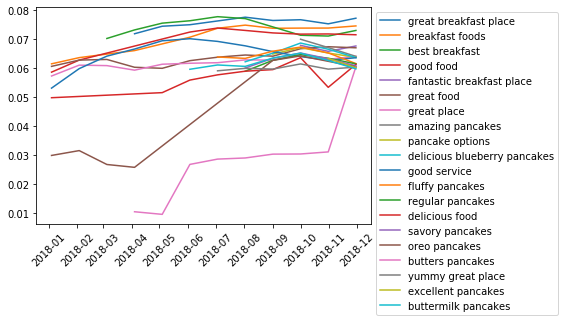

In [98]:
for k in df_keywords['keywords'][:topk]:
    df_tmp = df_keywords[df_keywords['keywords']==k]
    plt.plot(df_tmp['datetime'], df_tmp['rank'], label=k);
    plt.xticks(rotation=45)
    plt.legend(loc="upper left",
               bbox_to_anchor=(1.0, 1));

# Convert to JSON for D3.js

In [99]:
# convert to JSON
df_tmp = (df_keywords[['over', 'keywords', 'datetime', 'rank']]
    .sort_values(by=['over', 'keywords', 'datetime'])
    .pivot_table(values=['rank'], 
                 index=['datetime', 'over'],
                 columns=['keywords'])
    .reset_index(level=1)
    .fillna('null')
)
df_tmp.columns = ([df_tmp.columns[0][0]] +
                  [t[1] for t in df_tmp.columns[1:]])
df_tmp

,over,amazing pancakes,best breakfast,breakfast foods,buttermilk pancakes,butters pancakes,delicious blueberry pancakes,delicious food,excellent pancakes,fantastic breakfast place,fluffy pancakes,good food,good service,great breakfast place,great food,great place,oreo pancakes,pancake options,regular pancakes,savory pancakes,yummy great place
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-04,1,null,null,0.061491,null,null,null,0.0497637,null,null,null,0.0586091,0.053086,null,0.060613,0.057274,0.0297919,null,null,null,null
2018-02-03,2,null,null,0.0636316,null,null,null,null,null,null,null,0.0627806,0.059829,null,0.062783,0.061034,0.0314671,null,null,null,null
2018-03-05,3,null,0.0702622,0.0648612,null,null,null,null,null,null,null,null,0.064149,null,0.063002,0.060870,0.0266601,null,null,null,null
2018-04-04,4,null,0.0732167,0.0660669,null,0.0103122,null,null,null,null,null,null,0.066598,0.0719,0.060299,0.059298,0.0256775,null,null,null,null
2018-05-04,5,null,0.075564,null,null,0.00940865,null,0.051519,null,null,null,null,0.069468,0.0744957,0.059937,0.061351,null,null,null,null,null
2018-06-03,6,null,0.0763909,0.0706987,0.0596055,0.0266909,null,0.0558661,null,null,null,0.0724844,0.070176,0.0750185,0.062582,0.061686,null,null,null,null,null
2018-07-03,7,null,0.0778001,0.0737975,0.0610941,0.0285265,null,0.0576753,null,null,0.0638515,0.0738702,0.069247,null,0.063782,0.061879,null,null,null,null,0.0590755
2018-08-02,8,null,0.077138,0.0748795,0.0606062,0.028917,0.0622086,0.0589356,null,null,0.0633726,0.0730442,0.067718,0.077622,0.064538,0.062848,null,null,0.058933,0.0600397,0.0599254
2018-09-01,9,null,null,0.0737874,0.0634923,0.0302437,0.0651809,0.0594922,null,null,0.0658662,0.0721832,0.065707,0.0764883,0.064139,0.062766,0.0626929,0.0648581,0.0627185,0.0634088,0.0596742


In [106]:
l1 = df_keywords['keywords'][:topk]
# padding = len(max(l1))
# l2 = [s.ljust(padding) for s in l1]
dict(zip(l1, l1))
# cannot influence the key order of dictionary anyway
# do not use this for D3.js legend 

{'amazing pancakes': 'amazing pancakes',
 'best breakfast': 'best breakfast',
 'breakfast foods': 'breakfast foods',
 'buttermilk pancakes': 'buttermilk pancakes',
 'butters pancakes': 'butters pancakes',
 'delicious blueberry pancakes': 'delicious blueberry pancakes',
 'delicious food': 'delicious food',
 'excellent pancakes': 'excellent pancakes',
 'fantastic breakfast place': 'fantastic breakfast place',
 'fluffy pancakes': 'fluffy pancakes',
 'good food': 'good food',
 'good service': 'good service',
 'great breakfast place': 'great breakfast place',
 'great food': 'great food',
 'great place': 'great place',
 'oreo pancakes': 'oreo pancakes',
 'pancake options': 'pancake options',
 'regular pancakes': 'regular pancakes',
 'savory pancakes': 'savory pancakes',
 'yummy great place': 'yummy great place'}

In [111]:
print("{\'"+"',\n'".join([s+"':'"+s for s in l1])+"'}")
# use this unsorted output for D3.js legend

{'great breakfast place':'great breakfast place',
'breakfast foods':'breakfast foods',
'best breakfast':'best breakfast',
'good food':'good food',
'fantastic breakfast place':'fantastic breakfast place',
'great food':'great food',
'great place':'great place',
'amazing pancakes':'amazing pancakes',
'pancake options':'pancake options',
'delicious blueberry pancakes':'delicious blueberry pancakes',
'good service':'good service',
'fluffy pancakes':'fluffy pancakes',
'regular pancakes':'regular pancakes',
'delicious food':'delicious food',
'savory pancakes':'savory pancakes',
'oreo pancakes':'oreo pancakes',
'butters pancakes':'butters pancakes',
'yummy great place':'yummy great place',
'excellent pancakes':'excellent pancakes',
'buttermilk pancakes':'buttermilk pancakes'}


In [100]:
json_str = df_tmp.to_json(orient='index')
list(json.loads(json_str).values())

[{'amazing pancakes': 'null',
  'best breakfast': 'null',
  'breakfast foods': 0.0614909799,
  'buttermilk pancakes': 'null',
  'butters pancakes': 'null',
  'delicious blueberry pancakes': 'null',
  'delicious food': 0.0497637211,
  'excellent pancakes': 'null',
  'fantastic breakfast place': 'null',
  'fluffy pancakes': 'null',
  'good food': 0.0586091487,
  'good service': 0.0530862899,
  'great breakfast place': 'null',
  'great food': 0.0606127468,
  'great place': 0.0572742375,
  'oreo pancakes': 0.0297918873,
  'over': 1,
  'pancake options': 'null',
  'regular pancakes': 'null',
  'savory pancakes': 'null',
  'yummy great place': 'null'},
 {'amazing pancakes': 'null',
  'best breakfast': 'null',
  'breakfast foods': 0.0636316174,
  'buttermilk pancakes': 'null',
  'butters pancakes': 'null',
  'delicious blueberry pancakes': 'null',
  'delicious food': 'null',
  'excellent pancakes': 'null',
  'fantastic breakfast place': 'null',
  'fluffy pancakes': 'null',
  'good food': 0.06

# Slightly different outputs

CPU times: user 24.5 s, sys: 520 ms, total: 25 s
Wall time: 25 s


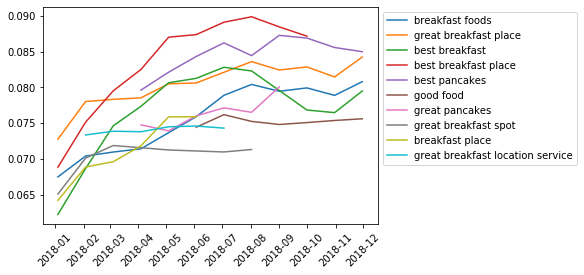

In [0]:
%%time
# for one business, to get a better trend of keywords,
# using 180 days (about 6 months) bagged reviews
business_id = 'Iq7NqQD-sESu3vr9iEGuTA'
current_date = datetime.strptime('2018-11-30', '%Y-%m-%d')
periods = 12
days_per_period = 30 # days
bagging_periods = 6
topk = 10

# load a spaCy model, depending on language, scale, etc.
nlp = spacy.load("en_core_web_sm")
# cutomize lemmatizer 
# https://spacy.io/api/lemmatizer
# ...
textrank = pytextrank.TextRank()
nlp.add_pipe(textrank.PipelineComponent, name="textrank", last=True)

keywords = []
for period in range(periods):
    # [starting_date, ending_date] = 180 days
    # or ending_date - staring_date = 170 days
    ending_date = current_date - timedelta(days=days_per_period * period)
    starting_date = ending_date - timedelta(days=days_per_period * bagging_periods -1)
    
    condition = ((df_reviews['business_id']==business_id) &
                (df_reviews['datetime']>=starting_date) &
                (df_reviews['datetime']<=ending_date))
    df_texts = df_reviews[condition][['text', 'datetime']]
    text = " ".join(df_texts['text'].to_list())
    doc = nlp(text)
    for i,p in enumerate(doc._.phrases):
        keywords.append([ending_date, p.rank, p.count, p.text, p.chunks])
        if i >= topk-1: break  

df_keywords = pd.DataFrame(keywords,
    columns=['datetime', 'rank', 'count', 'keywords', 'chunks'])

keywords_display = df_keywords['keywords'].value_counts().index[:topk]
for k in keywords_display:
    df_tmp = df_keywords[df_keywords['keywords']==k]
    plt.plot(df_tmp['datetime'], df_tmp['rank'], label=k)
    plt.xticks(rotation=45)
    plt.legend(loc="upper left",
               bbox_to_anchor=(1.0, 1));

# Test spaCy lemmatizer and lookups

In [0]:
spacy_lookups_data.en

{'lemma_exc': '/usr/local/lib/python3.6/dist-packages/spacy_lookups_data/data/en_lemma_exc.json',
 'lemma_index': '/usr/local/lib/python3.6/dist-packages/spacy_lookups_data/data/en_lemma_index.json',
 'lemma_lookup': '/usr/local/lib/python3.6/dist-packages/spacy_lookups_data/data/en_lemma_lookup.json',
 'lemma_rules': '/usr/local/lib/python3.6/dist-packages/spacy_lookups_data/data/en_lemma_rules.json'}

In [0]:
from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups
import spacy_lookups_data # for other languages

lookups = Lookups() 
lookups.add_table("lemma_rules", {"noun": [["s", ""]]})
print('lookups', len(lookups))
lemmatizer = Lemmatizer(lookups)
lemmas = lemmatizer("ducks", "NOUN")
print("lemmas == [\"duck\"]", lemmas == ["duck"])

lookups 1
lemmas == ["duck"] True


In [0]:
# pretrained models have lemmatizer
nlp = spacy.load("en_core_web_sm")
text = 'ducks foods'
doc = nlp(text)
for token in doc:
    print(token, token.lemma_)

ducks duck
foods foods
